### **The objective of conducting a well-test analysis is to test our reservoir for understanding some useful reservoir properties and conditions such as reservoir permeability, its extent or size, and the magnitude of the well skin. There are three basic tests:** 
* drawdown, 
* buildup, and 
* constant pressure test

*In this project, we will analyze three well-test results from two drawdown tests (constant rate and multiple rates), and a constant pressure test using the specified plots with Python*

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

C:\Users\lanci\AppData\Local\Temp\ipykernel_31720\2215533972.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [24]:
# creation of the parameters

poro = 0.15 # Porosity
rw = 0.333 # Wellbore radius, ft
h = 32 # Reservoir thickness, ft
ct = 12E-06 # Total compressibility, sip
pi = 2500 # Initial reservoir pressure, psia
mu_oil = 2 # Oil viscosity, cp
Bo = 1.333 # Oil FVF, RB/STB

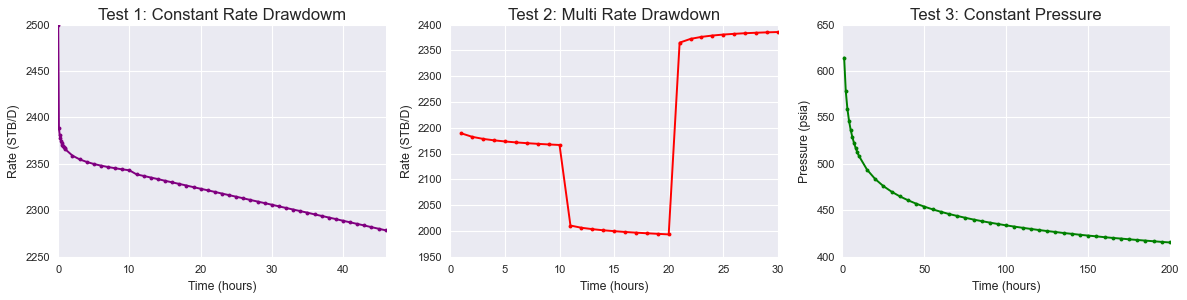

In [25]:
# There are 6 test datasets

import glob
import os

# get all paths and alphabetically ordered
paths = sorted(glob.glob(os.path.join(r"C:\Users\lanci\OneDrive\Desktop\welltest", "*.csv")))

plt.figure(figsize=(15,7))
titles = ['Test 1: Constant Rate Drawdowm', 'Test 2: Multi Rate Drawdown',
          'Test 3: Constant Pressure']
colors = ['purple', 'red', 'green']

for i in range(len(paths)):
  if i < 3:
    if i == 2:
      # pressure test
      df = pd.read_csv(paths[i])
      t = df.iloc[:,0].values # time column
      q = df.iloc[:,1].values # rate column

      plt.subplot(2,3,i+1)
      plt.plot(t, q, '.-', color=colors[i])
      plt.ylabel('Pressure (psia)')

    else:
      # rate test
      df = pd.read_csv(paths[i])
      t = df.iloc[:,0].values # time column
      p = df.iloc[:,1].values # pressure column
      
      plt.subplot(2,3,i+1)
      plt.plot(t, p, '.-', color=colors[i])
      plt.ylabel('Rate (STB/D)')
    
    plt.title(titles[i], size=15)
    plt.xlabel('Time (hours)')
    plt.xlim(0, max(t))

plt.tight_layout()
plt.show()

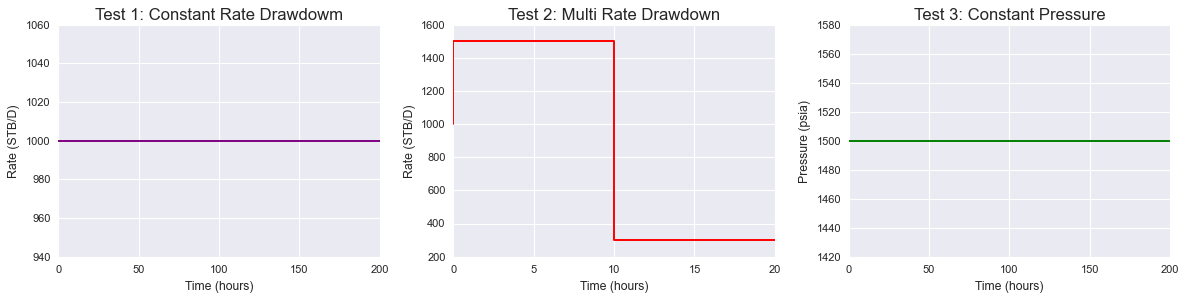

In [29]:
# test 1
t1 = [0, 100, 200]
q1 = [1000, 1000, 1000]

# test 2
t2 = [0, 10, 20]
q2 = [1000, 1500, 300]

# test 3
t3 = [0, 100, 200]
p3 = [1500, 1500, 1500]

x = np.array([t1, t2, t3])
y = np.array([q1, q2, p3])

plt.figure(figsize=(15,7))
titles = ['Test 1: Constant Rate Drawdowm', 'Test 2: Multi Rate Drawdown',
          'Test 3: Constant Pressure']
colors = ['purple', 'red', 'green']

for i in range(len(x)):
  if i == 2:
    plt.subplot(2,3,i+1)
    plt.step(x[i], y[i], color=colors[i])
    plt.ylabel('Pressure (psia)')
  
  else:
    plt.subplot(2,3,i+1)
    plt.step(x[i], y[i], color=colors[i])
    plt.ylabel('Rate (STB/D)')

  plt.title(titles[i], size=15)
  plt.xlim(0, max(x[i]))
  plt.xlabel('Time (hours)')

plt.tight_layout()
plt.show()


# **Constant Rate Drawdowm**

C:\Users\lanci\AppData\Local\Temp\ipykernel_31720\1204320185.py:87: RuntimeWarning: divide by zero encountered in log
  y_fit = m1 * np.log(t) + c1


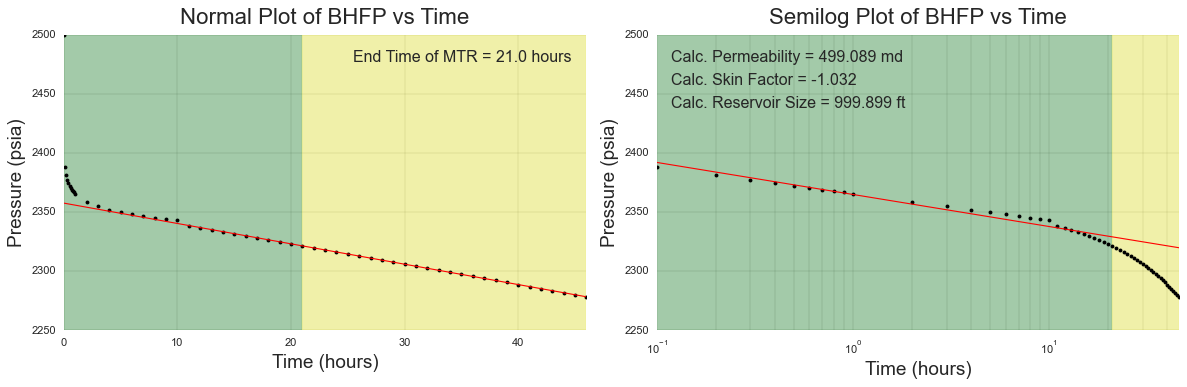

In [34]:
def constant_rate_drawdown_test(t, p, q, Bo, mu_oil, h, poro, ct, rw, pi, your_guess=5):
  """
  Analyzing Constant-Rate Well-test Result
  Note: Make your initial guess of the data index where LTR and MTR separate
  """
  import numpy as np
  import matplotlib.pyplot as plt
  from scipy.optimize import curve_fit
  import matplotlib.patches as mpl_patches  

  def permeability(q, Bo, mu_oil, h, m_cycle):
    """Calculate permeability from BHFP vs time semilog plot"""
    return (-162.6 * q * Bo * mu_oil) / (m_cycle * h)

  def skin_factor(pi, k, poro, mu_oil, ct, rw, c1, m_cycle):
    """
    Calculate skin factor from BHFP vs time semilog plot
    Note: k is the calculated permeability
    """
    return 1.1513 * (((pi - c1) / -m_cycle) - np.log10(k / (poro * mu_oil * ct * (rw**2))) + 3.2275)

  def reservoir_size(q, Bo, poro, h, ct, m2):
    """Calculate reservoir size from BHFP vs time normal plot"""
    return np.sqrt(-(.07447 * q * Bo) / (poro * h * ct * m2))

  def linear(x, a, b):
    return a * x + b

  " Analysis of MTR region to calculate permeability "

  t_crop1, p_crop1 = np.log(t[1:your_guess+1]), p[1:your_guess+1]
  popt, pcov = curve_fit(linear, t_crop1, p_crop1)
  m1, c1 = popt[0], popt[1]

  # calculate permeability
  m_cycle = m1 * np.log(10) # slope has unit psi/cycle
  k = permeability(q, Bo, mu_oil, h, m_cycle)

  # calculate skin factor
  s = skin_factor(pi, k, poro, mu_oil, ct, rw, c1, m_cycle)

  " Analysis of LTR region to calculate reservoir size "

  t_crop2, p_crop2 = t[your_guess:], p[your_guess:]
  popt, pcov = curve_fit(linear, t_crop2, p_crop2)
  m2, c2 = popt[0], popt[1]

  # calculate reservoir size
  re = reservoir_size(q, Bo, poro, h, ct, m2)

  " Plot Analysis "

  plt.figure(figsize=(15,5))

  # normal plot BHFP vs time
  plt.subplot(1,2,1)
  plt.plot(t, p, '.', color='black')

  ## plot the regression line
  y_fit = m2 * t + c2
  plt.plot(t, y_fit, color='red', linewidth=1)

  ## plot the separate MTR and LTR region
  plt.axvspan(0, t[your_guess], color='green', alpha=0.3)
  plt.axvspan(t[your_guess], max(t), color='yellow', alpha=0.3)

  plt.title('Normal Plot of BHFP vs Time', size=20, pad=10)
  plt.xlabel('Time (hours)', size=17); plt.ylabel('Pressure (psia)', size=17)
  plt.xlim(0,max(t))

  # output all results to plot
  labels2 = []
  labels2.append("End Time of MTR = {} hours".format(np.round(t[your_guess], 3)))
  handles2 = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                  lw=0, alpha=0)] * 1                                    

  plt.legend(handles2, labels2, loc='best', fontsize='large', 
              fancybox=True, framealpha=0.7, 
              handlelength=0, handletextpad=0)
  plt.grid(True, which='both', color='black', linewidth=0.1)

  # semilog plot BHFP vs time
  plt.subplot(1,2,2)
  plt.semilogx(t, p, '.', color='black')

  ## plot the regression line
  y_fit = m1 * np.log(t) + c1
  plt.plot(t, y_fit, color='red', linewidth=1)

  ## plot the separate MTR and LTR region
  plt.axvspan(0, t[your_guess], color='green', alpha=0.3)
  plt.axvspan(t[your_guess], max(t), color='yellow', alpha=0.3)  

  plt.title('Semilog Plot of BHFP vs Time', size=20, pad=10)
  plt.xlabel('Time (hours)', size=17); plt.ylabel('Pressure (psia)', size=17)
  plt.xlim(xmax=max(t))

  # output all results into the plot
  labels1 = []
  labels1.append("Calc. Permeability = {} md".format(np.round(k, 3)))
  labels1.append("Calc. Skin Factor = {}".format(np.round(s, 3)))
  labels1.append("Calc. Reservoir Size = {} ft".format(np.round(re, 3)))  
  handles1 = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                  lw=0, alpha=0)] * 3 

  plt.legend(handles1, labels1, loc='best', fontsize='large', 
              fancybox=True, framealpha=0.7, 
              handlelength=0, handletextpad=0) 
  
  plt.grid(True, which='both', color='black', linewidth=0.1)

  plt.tight_layout() 
  plt.show()



# load well-test data
df = pd.read_csv(r"C:\Users\lanci\OneDrive\Desktop\welltest\welltest1_constant_rate_drawdown.csv")

t = df['t'].values
p = df['p'].values

# define rate
q = 1000 # Well rate, STB/D

# guess time index (input to user)
your_guess = 30

# well-test analysis
constant_rate_drawdown_test(t, p, q, Bo, mu_oil, h, poro, ct, rw, pi, your_guess)


# **Multi Rate Drawdown**

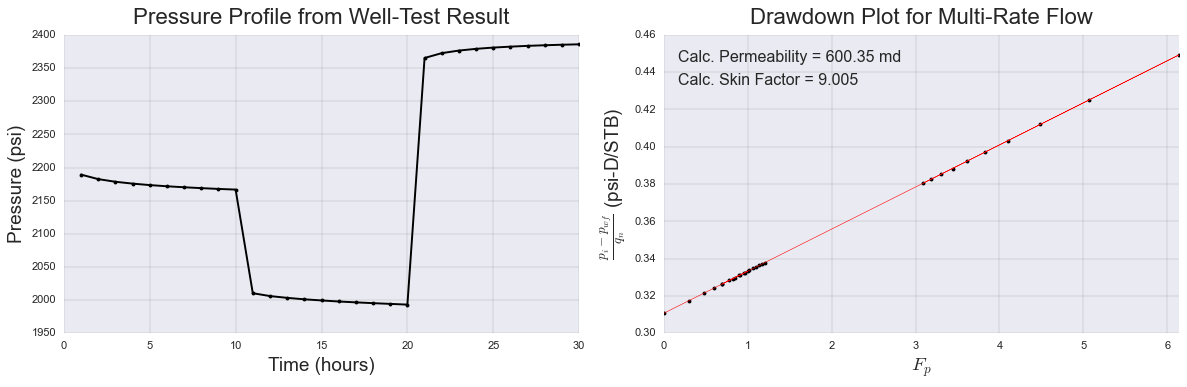

In [37]:
def multi_rate_drawdown_test(t, p, t_change, q_change, Bo, mu_oil, h, poro, ct, rw, pi):
  """
  Analyzing Multi-Rate Well-test Result
  """
  import numpy as np
  import matplotlib.pyplot as plt
  from scipy.optimize import curve_fit
  import matplotlib.patches as mpl_patches  

  def permeability(Bo, mu_oil, h, m):
    """Calculate permeability from drawdown plot"""
    return (162.6 * Bo * mu_oil) / (m * h)

  def skin_factor(k, poro, mu_oil, ct, rw, c, m):
    """
    Calculate skin factor from drawdown plot
    Note: k is the calculated permeability
    """
    return 1.1513 * ((c / m) - np.log10(k / (poro * mu_oil * ct * (rw**2))) + 3.2275)

  def linear(x, a, b):
    return a * x + b
  
  # calculate delta rate (Δq)
  t_change = np.append(0, t_change)
  delta_q = [j-i for i, j in zip(q_change[:-1], q_change[1:])]
  delta_q = np.concatenate((np.array([0, q_change[0]]), delta_q))

  # create rate step profile
  time_arr = []
  rate_arr = []
  x = []
  y = []

  " Calculate the x-axis and y-axis "

  for i in range(len(t)):  
      for j in range(0, len(t_change)-1):
          if t[i] > t_change[j] and t[i] <= t_change[j+1]:
              # produce t and q profile
              time_arr.append(t[i])
              rate_arr.append(q_change[j])

              # calculate Fp as x-axis
              tn = np.log10(t[i] - t_change[:j+1])
              delta_qn = delta_q[1:j+2] / q_change[j]
              tn_mult_delta_qn = tn * delta_qn
              Fp = np.sum(tn_mult_delta_qn)
              x.append(Fp)

              # calculate ((pi - pwf) / qn) as y-axis
              y_ = (pi - p[i]) / q_change[j]
              y.append(y_)

  # regression to the drawdown plot
  popt, pcov = curve_fit(linear, x, y)
  m, c = popt[0], popt[1]

  # calculate permeability
  k = permeability(Bo, mu_oil, h, m)

  # calculate skin factor
  s = skin_factor(k, poro, mu_oil, ct, rw, c, m)

  # output calculated results to plot
  labels1 = []
  labels1.append("Calc. Permeability = {} md".format(np.round(k, 3)))
  labels1.append("Calc. Skin Factor = {}".format(np.round(s, 3)))
  handles1 = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                  lw=0, alpha=0)] * 2

  " Plot Analysis "

  plt.figure(figsize=(15,5))

  plt.subplot(1,2,1)
  plt.plot(time_arr, p, '.-', color='black')
  plt.xlim(0, max(t))
  plt.title('Pressure Profile from Well-Test Result', size=20, pad=10)
  plt.xlabel(r'Time (hours)', size=17); plt.ylabel(r'Pressure (psi)', size=17)
  plt.grid(True, which='both', color='black', linewidth=0.1)

  plt.subplot(1,2,2)
  plt.plot(x, y, '.', color='black')
  plt.xlim(0, max(x))
  plt.title('Drawdown Plot for Multi-Rate Flow', size=20, pad=10)
  plt.xlabel(r'$F_p$', size=17); plt.ylabel(r'$\frac{p_i-p_{wf}}{q_n}$ (psi-D/STB)', size=17)

  # plot regression line
  y_fit = m * np.array(x) + c
  plt.plot(x, y_fit, color='red', linewidth=0.5)

  plt.legend(handles1, labels1, loc='best', fontsize='large', 
              fancybox=True, framealpha=0.7, 
              handlelength=0, handletextpad=0) 
  plt.grid(True, which='both', color='black', linewidth=0.1)
  plt.tight_layout()
  plt.show()  







# load well-test data
df = pd.read_csv(r"C:\Users\lanci\OneDrive\Desktop\welltest\welltest2_multi_rate_drawdown.csv")

t = df['t'].values
p = df['p'].values

# define rate-time steps
t_change = np.array([10, 20, 30])
q_change = np.array([1000, 1500, 300])

# well-test analysis
multi_rate_drawdown_test(t, p, t_change, q_change, Bo, mu_oil, h, poro, ct, rw, pi)

## **Constant pressure Test**

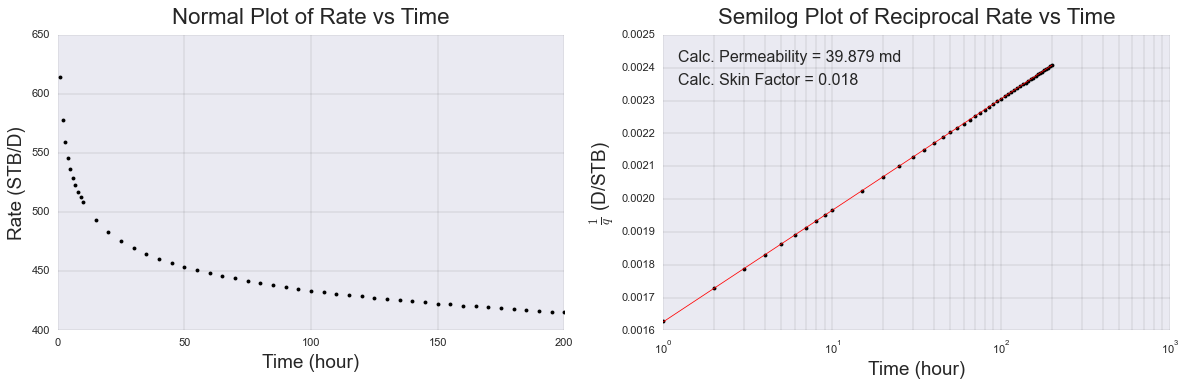

In [40]:
def constant_pressure_test(t, q, pwf, pi, Bo, mu_oil, h, poro, ct, rw):
  """
  Analyzing Constant Pressure Well-test Result
  """
  import numpy as np
  import matplotlib.pyplot as plt
  from scipy.optimize import curve_fit
  import matplotlib.patches as mpl_patches  

  def permeability(Bo, mu_oil, h, m):
    """Calculate permeability from semilog plot"""
    return (162.6 * Bo * mu_oil) / (m * h * (pi - pwf))

  def skin_factor(k, poro, mu_oil, ct, rw, c, m):
    """
    Calculate skin factor from semilog plot
    Note: k is the calculated permeability
    """
    return 1.1513 * ((c / m) - np.log10(k / (poro * mu_oil * ct * (rw**2))) + 3.2275)

  def linear(x, a, b):
    return a * x + b
  
  # linear regression
  x, y = np.log10(t), 1/q
  popt, pcov = curve_fit(linear, x, y)
  m, c = popt[0], popt[1]

  plt.figure(figsize=(15,5))

  # calculate permeability
  k = permeability(Bo, mu_oil, h, m)

  # calculate skin factor
  s = skin_factor(k, poro, mu_oil, ct, rw, c, m)

  # output calculated results to plot
  labels1 = []
  labels1.append("Calc. Permeability = {} md".format(np.round(k, 3)))
  labels1.append("Calc. Skin Factor = {}".format(np.round(s, 3)))
  handles1 = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                  lw=0, alpha=0)] * 2

  # normal plot of q vs t
  plt.subplot(1,2,1)
  plt.plot(t, q, '.', color='black')
  plt.title('Normal Plot of Rate vs Time', size=20, pad=10)
  plt.xlabel('Time (hour)', size=17); plt.ylabel(r'Rate (STB/D)', size=17)  
  plt.xlim(0, max(t))

  plt.grid(True, which='both', color='black', linewidth=0.1)

  # plot semilog plot of 1/q vs t
  plt.subplot(1,2,2)
  plt.semilogx(t, 1/q, '.', color='black')
  plt.title('Semilog Plot of Reciprocal Rate vs Time', size=20, pad=10)
  plt.xlabel('Time (hour)', size=17); plt.ylabel(r'$\frac{1}{q}$ (D/STB)', size=17)
  plt.xlim(xmin=1)

  # plot regression line
  y_fit = m * np.log10(t) + c
  plt.plot(t, y_fit, color='red', linewidth=0.7)

  plt.legend(handles1, labels1, loc='best', fontsize='large', 
              fancybox=True, framealpha=0.7, 
              handlelength=0, handletextpad=0) 

  plt.grid(True, which='both', color='black', linewidth=0.1)

  plt.tight_layout()
  plt.show()  




# load well-test data
df = pd.read_csv(r"C:\Users\lanci\OneDrive\Desktop\welltest\welltest3_constant_pressure.csv")

t = df['t'].values
q = df['q'].values

# define flowing pressure
pwf = 1500 # Wellbore Flowing Pressure, psia

# well-test analysis
constant_pressure_test(t, q, pwf, pi, Bo, mu_oil, h, poro, ct, rw)